## Module 5 Class activities
This notebook is a starting point for the exercises and activities that we'll do in class. We'll do an extension of the random forests classifier, looking at a continuous variable.

Before you attempt any of these activities, make sure to watch the video lectures for this module.

### Classification: NYC evictions
We'll look at the factors that are associated with evictions in New York City. Perhaps a machine learning model can identify the types of places that are vulnerable to eviction, and target renter assistance programs more effectively?

#### Loading in the data

Let's start by loading in the [eviction dataset](https://data.cityofnewyork.us/City-Government/Evictions/6z8x-wfk4) via Socrata.

<div class="alert alert-block alert-info">

<strong>Exercise:</strong> Import the data from Socrata via the API into a pandas DataFrame.
</div>

*Hints*:
- Look back at Week 1 if you need a refresher on using Socrata
- There are about 70,000 rows in the dataset. So remember to add `?$limit=100000` to the end of the URL that you pass to `requests.get()`. Otherwise, you'll just get the first 1,000 rows. (The limit can be anything comfortably above 70000.)

In [1]:
import requests
import json
import pandas as pd
import geopandas as gpd
url = 'https://data.cityofnewyork.us/resource/6z8x-wfk4.json?$limit=100000'
r = requests.get(url)
df = pd.DataFrame(json.loads(r.text))
df.head()

# your code here

,court_index_number,docket_number,eviction_address,eviction_apt_num,executed_date,marshal_first_name,marshal_last_name,residential_commercial_ind,borough,eviction_zip,ejectment,eviction_possession,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
0,60835/16,067937,800 ST. ANN'S AVENUE,11K,2018-02-13T00:00:00.000,Henry,Daley,Residential,BRONX,10456,Not an Ejectment,Possession,40.820818,-73.910040,1,17,75,2117696,2026187501,Melrose South-Mott Haven North
1,72503/19,107531,153-21 134TH AVENUE,2ND FLOOR,2022-03-28T00:00:00.000,Justin,Grossman,Residential,QUEENS,11434,Not an Ejectment,Possession,40.670269,-73.782793,12,28,294,4266194,4122780034,Springfield Gardens North
2,3005/19,352734,533 TINTON AVENUE,53,2019-04-10T00:00:00.000,Thomas,Bia,Residential,BRONX,10455,Not an Ejectment,Possession,40.812312,-73.906468,1,8,35,2003959,2025810028,Mott Haven-Port Morris
3,74543/18,21449,21-14 33RD AVENUE,NaN,2019-01-30T00:00:00.000,Edward,Guida,Residential,QUEENS,11106,Not an Ejectment,Possession,40.764511,-73.932036,1,22,45,4006433,4005560127,Astoria
4,58634/16,322623,1776 CASTLE HILL AVENUE,1E,2017-03-29T00:00:00.000,John,Villanueva,Residential,BRONX,10462,Not an Ejectment,Possession,40.841803,-73.853212,10,18,204,2042266,2039980010,Westchester-Unionport


<div class="alert alert-block alert-info">

<strong>Exercise:</strong> Convert your dataframe to a GeoDataFrame, using the latitude and longitude columns.

In [2]:
# your code here 
eviction_gdf =gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.longitude, df.latitude, crs='EPSG:4326'))
eviction_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 75201 entries, 0 to 75200
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   court_index_number          75201 non-null  object  
 1   docket_number               75201 non-null  object  
 2   eviction_address            75201 non-null  object  
 3   eviction_apt_num            62829 non-null  object  
 4   executed_date               75201 non-null  object  
 5   marshal_first_name          75201 non-null  object  
 6   marshal_last_name           75201 non-null  object  
 7   residential_commercial_ind  75201 non-null  object  
 8   borough                     75201 non-null  object  
 9   eviction_zip                75201 non-null  object  
 10  ejectment                   75201 non-null  object  
 11  eviction_possession         75201 non-null  object  
 12  latitude                    67983 non-null  object  
 13  longitud

Now let's import some census data. We could use `cenpy` or the Census Bureau API. But to keep things simple so that we can focus on the spatial joins and the machine learning, I downloaded the block group-level 2019 ACS data for New York from the [Census Bureau](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-data.html). To save space, I clipped it to the 5 NYC counties.

It's in your repository, and we can load it in as follows. If you aren't familiar with a GeoPackage (GPKG) format, think of it as a "new and improved shapefile." [Here's a good overview.](https://towardsdatascience.com/why-you-need-to-use-geopackage-files-instead-of-shapefile-or-geojson-7cb24fe56416)

In [3]:
bgs = gpd.read_file('../data/nyc_bgs.gpkg')
bgs.head()

,GEOID,B01001e1,B01001e10,B01001e11,B01001e12,B01001e13,B01001e14,B01001e15,B01001e16,B01001e17,...,B19001e8,B19001e9,B22010e1,B22010e2,B22010e3,B22010e4,B22010e5,B22010e6,B22010e7,geometry
0,15000US360050175002,656,39,0,0,0,18,14,0,22,...,11,0,358,214,139,75,144,107,37,"POLYGON ((-73.91570 40.83054, -73.91485 40.830..."
1,15000US360050141001,1228,0,35,96,26,45,28,0,54,...,34,0,503,291,226,65,212,70,142,"POLYGON ((-73.91661 40.82499, -73.91592 40.825..."
2,15000US360050145001,2716,44,192,33,38,76,30,64,93,...,137,83,972,534,316,218,438,7,431,"POLYGON ((-73.90584 40.83106, -73.90505 40.832..."
3,15000US360050075002,3488,43,109,122,169,19,51,139,22,...,63,37,1188,470,300,170,718,147,571,"POLYGON ((-73.91035 40.81995, -73.91022 40.820..."
4,15000US360050418001,657,0,38,5,11,21,14,43,25,...,0,0,217,87,18,69,130,41,89,"POLYGON ((-73.86288 40.89515, -73.86146 40.897..."


Note that the variables aren't particularly carefully selected - I just threw in many of the demographic and housing variables. 

Nor are the variable names particularly informative, but the full names are in a file in the repository.

In [4]:
# note it is tab-sepated, not comma separated
# so we use the sep='\t' argument

col_names = pd.read_csv('../data/BG_METADATA_2019.txt', sep='\t', index_col='Short_Name')
col_names.head()

,Full_Name
Short_Name,
B01001e1,SEX BY AGE: Total: Total population -- (Estimate)
B01001m1,SEX BY AGE: Total: Total population -- (Margin...
B01001e2,SEX BY AGE: Male: Total population -- (Estimate)
B01001m2,SEX BY AGE: Male: Total population -- (Margin ...
B01001e3,SEX BY AGE: Male: Under 5 years: Total populat...


In [57]:
col_names

,Full_Name
Short_Name,
B01001e1,SEX BY AGE: Total: Total population -- (Estimate)
B01001m1,SEX BY AGE: Total: Total population -- (Margin of Error)
B01001e2,SEX BY AGE: Male: Total population -- (Estimate)
B01001m2,SEX BY AGE: Male: Total population -- (Margin of Error)
B01001e3,SEX BY AGE: Male: Under 5 years: Total population -- (Estimate)
...,...
B99283m3,"ALLOCATION OF HOUSEHOLD INTERNET SUBSCRIPTION TYPE: Total: Broadband such as cable, fiberoptic, or DSL, satellite, and other service: Households -- (Margin of Error)"
B99283e4,ALLOCATION OF HOUSEHOLD INTERNET SUBSCRIPTION TYPE: Total: Cellular data plan: Households -- (Estimate)
B99283m4,ALLOCATION OF HOUSEHOLD INTERNET SUBSCRIPTION TYPE: Total: Cellular data plan: Households -- (Margin of Error)


So you can see the definition of the column like this. (I don't recommend renaming the `bg` column names, because the full names are so long.)

In [5]:
col_names.loc['B01001e1']

Full_Name    SEX BY AGE: Total: Total population -- (Estimate)
Name: B01001e1, dtype: object

#### Spatial join
Now let's do the spatial join. Again, let's follow our three step process.

1. Use a spatial join to add the `GEOID` column to the evictions dataframe. *Hint:* Check your projections.
2. Group by `GEOID` to get a count of evictions per block group. If you have a `Series`, give it a name - maybe `n_evictions`
3. Join those counts back - a tabular join based on the index

In [6]:
#bgs.set_index('GEOID',inplace=True)

<div class="alert alert-block alert-info">
    <strong>Exercise:</strong> Add a count of evictions per census block group to your <strong>bgs</strong> GeoDataFrame, using the 3-step process above.
</div>

In [7]:
# your code here
#bgs.head(1)
bgs.to_crs('EPSG:4326', inplace=True)
eviction_join = gpd.sjoin(bgs[['GEOID','geometry']], eviction_gdf, how="inner", predicate='intersects')
n_evictions=eviction_join.groupby('GEOID')['GEOID'].count()

bgs.set_index('GEOID',inplace=True)
bgs_eviction=bgs.join(n_evictions)

In [8]:
bgs_eviction.rename(columns={'GEOID':'n_evictions'}, inplace=True)
bgs_eviction

,B01001e1,B01001e10,B01001e11,B01001e12,B01001e13,B01001e14,B01001e15,B01001e16,B01001e17,B01001e18,...,B19001e9,B22010e1,B22010e2,B22010e3,B22010e4,B22010e5,B22010e6,B22010e7,geometry,n_evictions
GEOID,,,,,,,,,,,,,,,,,,,,,
15000US360050175002,656,39,0,0,0,18,14,0,22,0,...,0,358,214,139,75,144,107,37,"POLYGON ((-73.91570 40.83054, -73.91485 40.830...",26.0
15000US360050141001,1228,0,35,96,26,45,28,0,54,0,...,0,503,291,226,65,212,70,142,"POLYGON ((-73.91661 40.82499, -73.91592 40.825...",34.0
15000US360050145001,2716,44,192,33,38,76,30,64,93,71,...,83,972,534,316,218,438,7,431,"POLYGON ((-73.90584 40.83106, -73.90505 40.832...",40.0
15000US360050075002,3488,43,109,122,169,19,51,139,22,31,...,37,1188,470,300,170,718,147,571,"POLYGON ((-73.91035 40.81995, -73.91022 40.820...",93.0
15000US360050418001,657,0,38,5,11,21,14,43,25,2,...,0,217,87,18,69,130,41,89,"POLYGON ((-73.86287 40.89515, -73.86146 40.897...",28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15000US360850323001,1073,50,25,22,5,24,74,36,78,13,...,29,451,79,19,60,372,25,347,"POLYGON ((-74.19592 40.63522, -74.19589 40.635...",17.0
15000US360850134002,1020,13,39,27,0,23,72,99,14,22,...,0,421,9,9,0,412,134,278,"POLYGON ((-74.11957 40.56695, -74.11904 40.567...",2.0
15000US360850187011,840,4,27,39,20,50,22,29,19,12,...,11,283,5,0,5,278,61,217,"POLYGON ((-74.13230 40.61244, -74.13131 40.612...",2.0


<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Do a quick-and-dirty map of the number of evictions. This will help identify any data holes.
</div>

[]

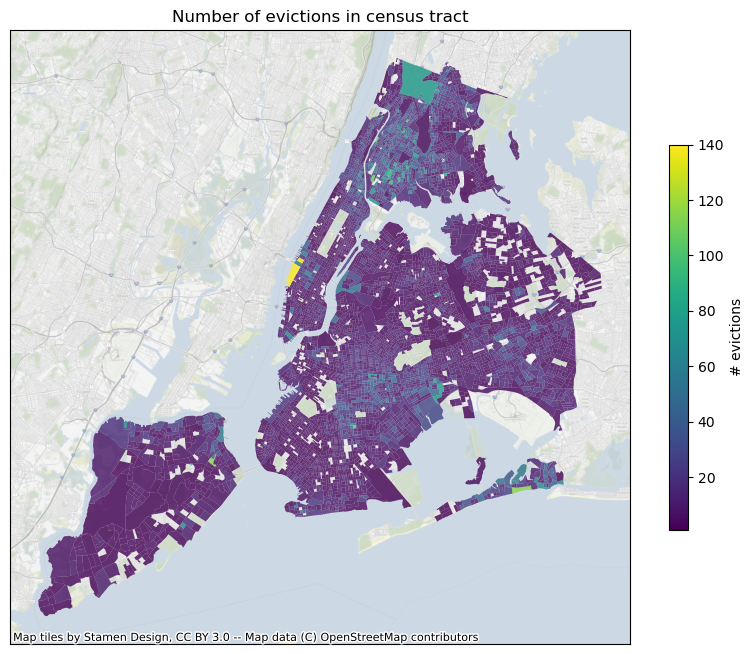

In [13]:
# your code here
import matplotlib.pyplot as plt
import contextily as ctx

fig, ax = plt.subplots(figsize=(10,10))

# plot all the schools first, so we don't ignore those ones with zero collisions
bgs_eviction.to_crs('EPSG:3857').plot(ax=ax, column='n_evictions', alpha=0.8, legend=True, 
                                      legend_kwds={'orientation': 'vertical', 'shrink': 0.5, 'label':"# evictions"})
# plot the proportional markers
#bgs_eviction.to_crs('EPSG:3857').plot(markersize='n_evictions', color='b', ax=ax)

ctx.add_basemap(ax=ax, alpha=0.5, zoom=13)
ax.set_title('Number of evictions in census tract')
ax.set_xticks([])
ax.set_yticks([])

#### Random forests regressor
Now we have our data set. Let's estimate a random forests model.

In contrast to the examples in the lecture, we are trying to predict a continuous variable - the number of evictions. So our classifier isn't appropriate. 

However, there is a similar model: the [random forest regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor). It works almost identically to the classifier. The main difference from a user perspective is assessing model performance - a confusion matrix doesn't work here.

You'll need to follow the following steps:
- choose your x variables. (Your y variable will be `n_evictions`)
- Drop Null values if needed
- split your dataset into training and testing portions
- estimate (fit) the model

<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Estimate a random forest regressor model to predict the number of evictions per census tract.</div>

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# your code here
# defining x and y variables
#https://stackoverflow.com/questions/36268749/how-to-remove-multiple-items-from-a-list-in-just-one-statement
xvars=list(set(bgs_eviction.columns.to_list())-set(['geometry', 'n_evictions']))
yvar='n_evictions'

# create a dataframe with no NaNs
df_to_fit = bgs_eviction[xvars+[yvar]].dropna()

# train-split
X_train, X_test, y_train, y_test = train_test_split(df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

# check we have a reasonable split
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))


# initialize the random forest classifer object
rf = RandomForestRegressor(n_estimators = 50, random_state = 1)

# now fit the model
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print('Predicted fraction True: {:.4f}. Actual fraction True: {:.4f}'.format(y_pred.mean(), y_test.mean()))
    

4343 4343
1448 1448
Predicted fraction True: 11.6784. Actual fraction True: 11.6989


<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Examine some of your trees in the random forest. What do they tell you?</div>

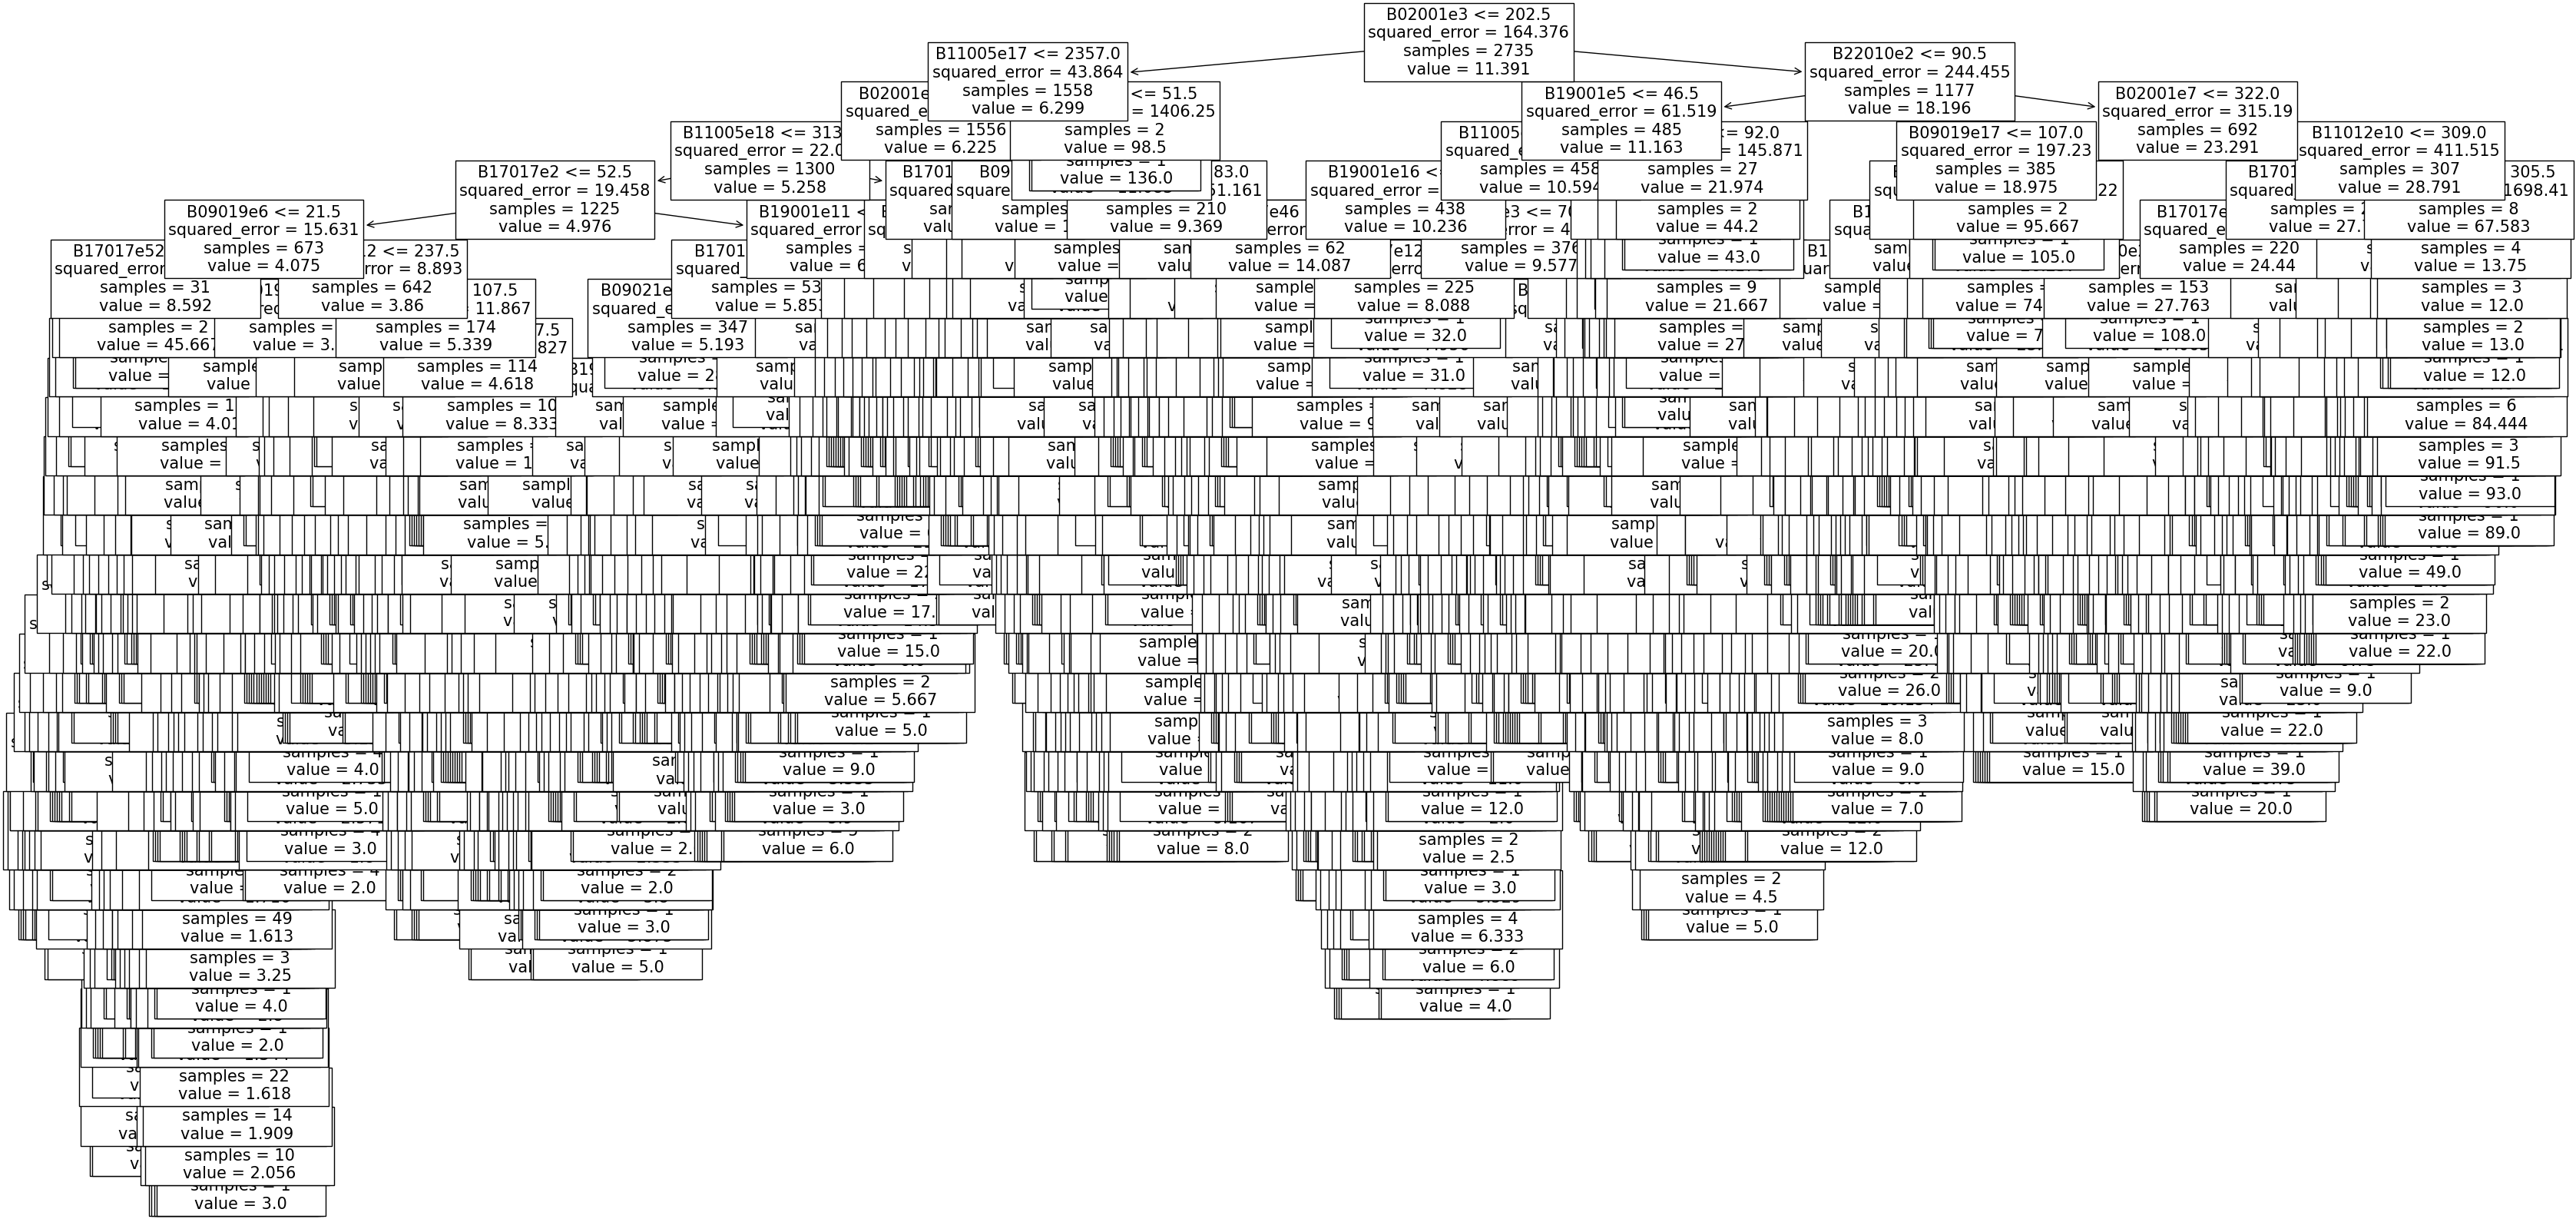

In [42]:
# your code here

# now we have 100 estimators (trees), so let's pick the first one to visualize
e = rf.estimators_[0]

from sklearn import tree
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(100,50))  
_ = tree.plot_tree(e, feature_names = X_train.columns, fontsize=15, ax = ax)

<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Experiment with different model hyperparameters and variables. Discuss your rationale and the results with a neighbor.</div>

In [55]:
# your code here

xvars2=random.sample(xvars,20)
print(len(xvars2))

# create a dataframe with no NaNs
df_to_fit = bgs_eviction[xvars2+[yvar]].dropna()

# train-split
X_train, X_test, y_train, y_test = train_test_split(df_to_fit[xvars2], df_to_fit[yvar], test_size = 0.25, random_state = 1)

# check we have a reasonable split
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))


# initialize the random forest classifer object
rf = RandomForestRegressor(n_estimators = 50, random_state = 1)

# now fit the model
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print('Predicted fraction True: {:.4f}. Actual fraction True: {:.4f}'.format(y_pred.mean(), y_test.mean()))

20
4343 4343
1448 1448
Predicted fraction True: 12.0170. Actual fraction True: 11.6989


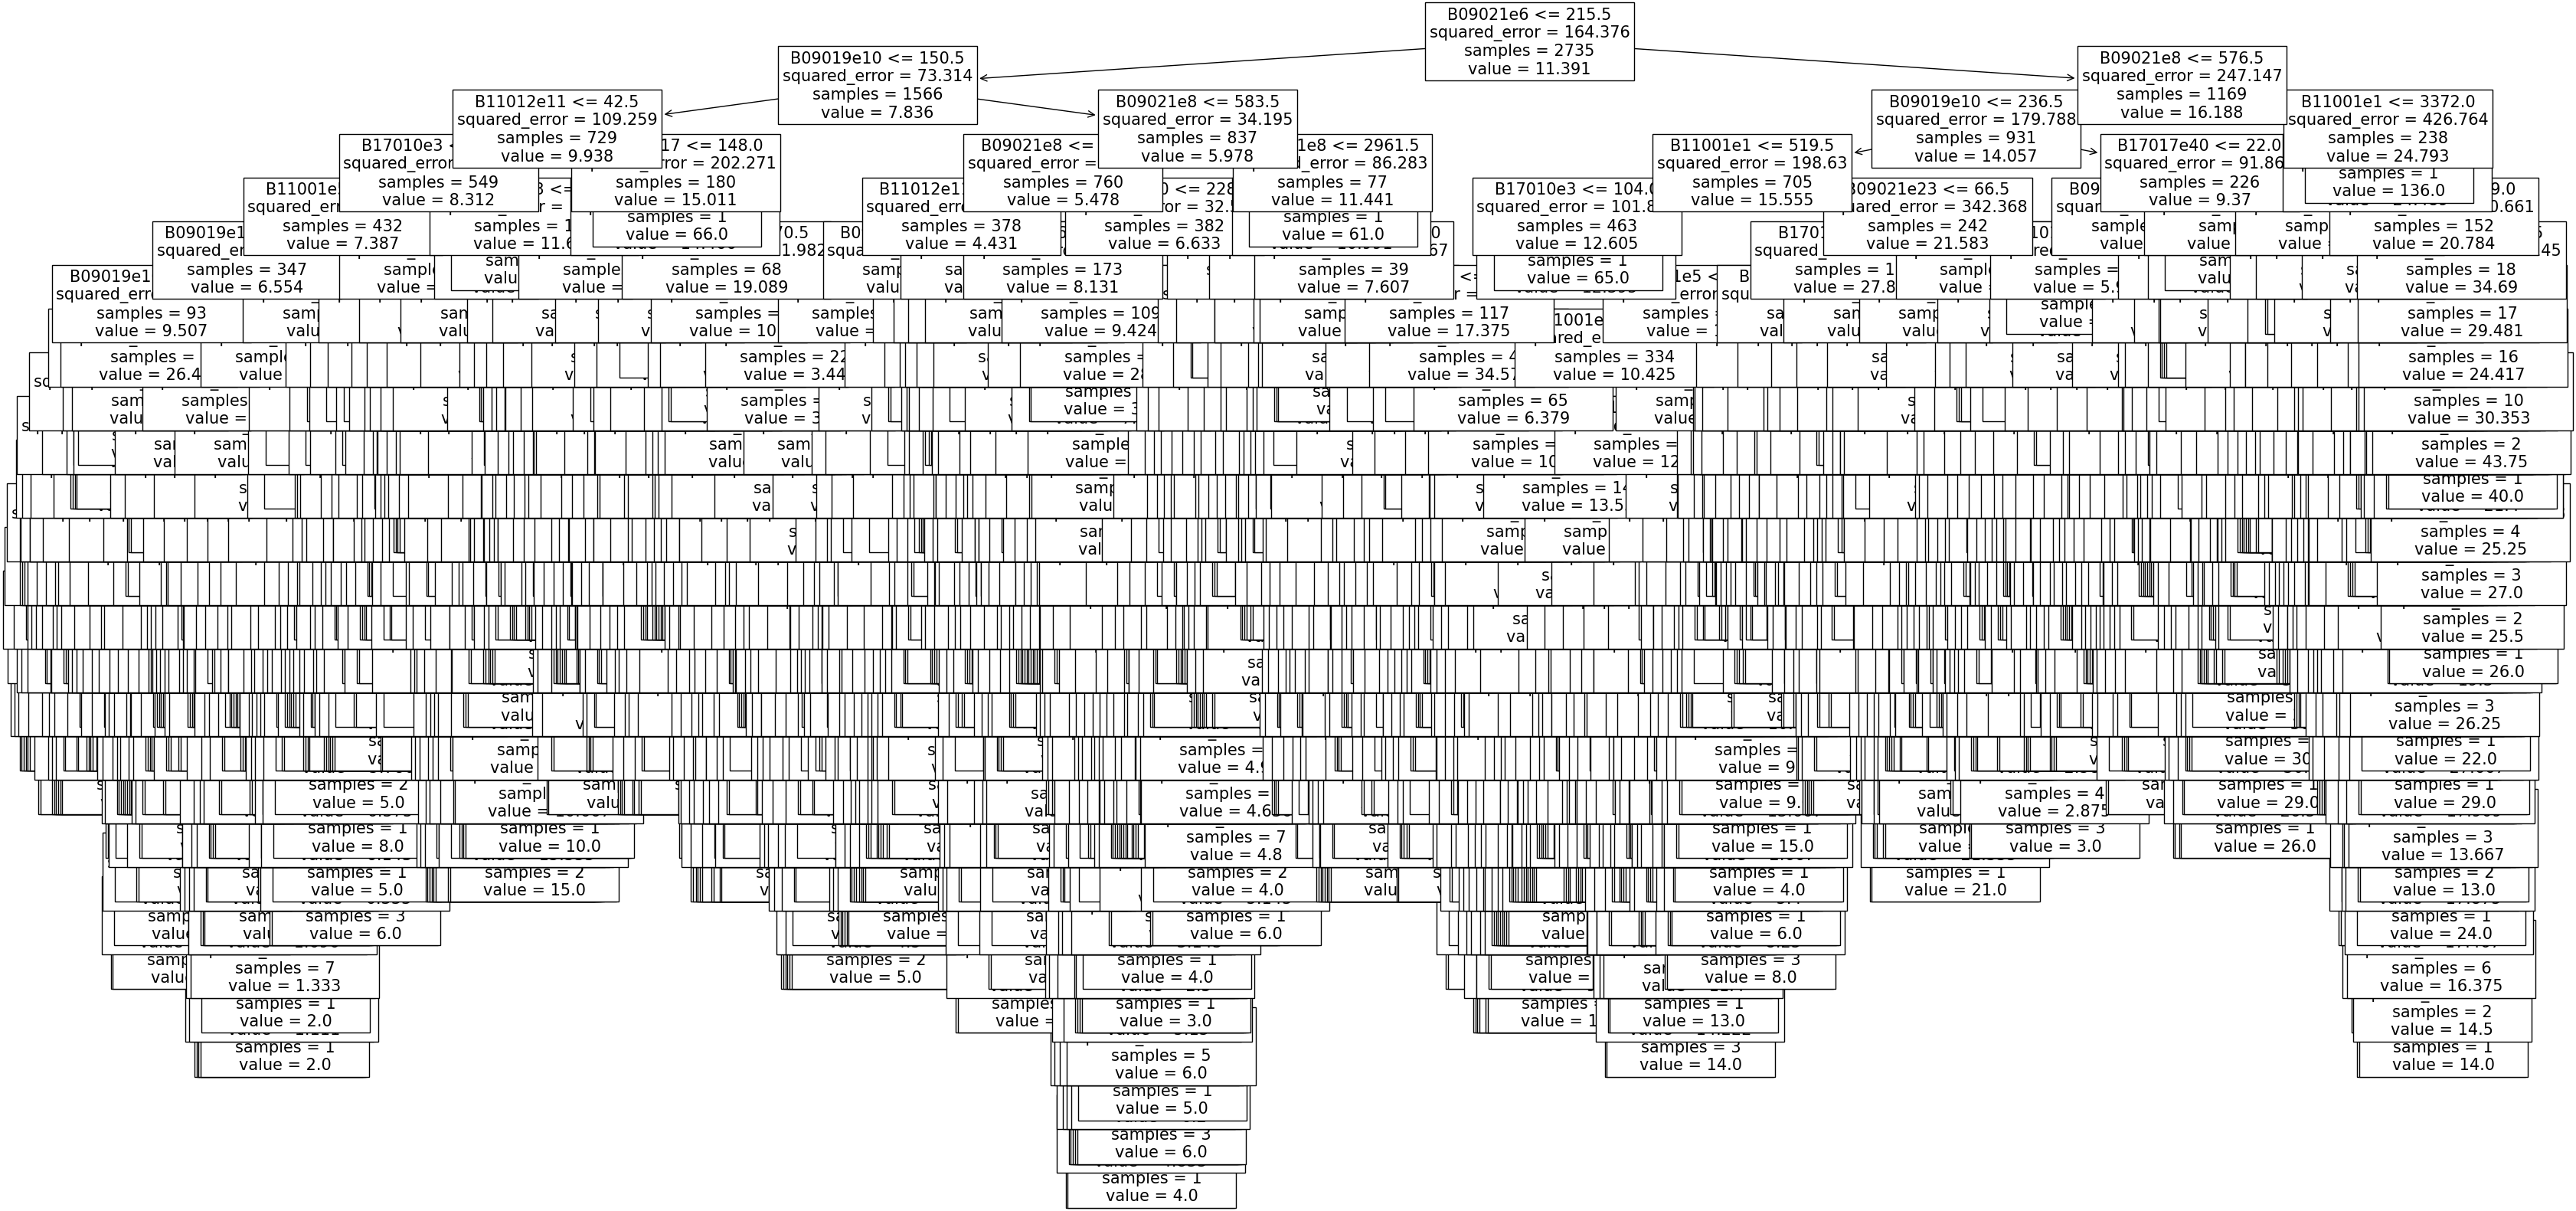

In [56]:
e = rf.estimators_[0]

fig, ax = plt.subplots(figsize=(40,20))  
_ = tree.plot_tree(e, feature_names = X_train.columns, fontsize=15, ax = ax)

The following questions relate to some of the material in Module 6. You might want to wait until watching those lectures. Then come back and complete these tasks.

<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Assess the fit of your model.</div>

Remember, the confusion matrix and accuracy scores don't apply to continuous data. Some ideas for continuous variables are [here](https://stackoverflow.com/questions/50789508/random-forest-regression-how-do-i-analyse-its-performance-python-sklearn). You could also plot actual vs predicted values.

In [ ]:
# your code here

<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Which variables are most important in your predictions? Plot the forest importances.</div>

In [ ]:
# your code here


<div class="alert alert-block alert-info">
<h3>What you should have learned</h3>
<ul>
  <li>Get more practice with spatial joins and Socrata.</li>
  <li>Learn how to estimate a random forests model for continuous data.</li>
</ul>
</div>